In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString
from shapely.geometry import Point
import matplotlib.pyplot as plt
from pyproj import Transformer

# # celý DF/GeoDF vypisovat bez limitu
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)

In [2]:
# df_raw -> df_clean
df_raw = pd.read_excel('../../data/europe/data_europe.xlsx')

df_clean = (
    df_raw
    .rename(columns={'University ↓ / Student →': 'destination'})
    .melt(
        id_vars='destination',
        var_name='origin',
        value_name='value'
    )
    .dropna(subset=['value'])
)
df_clean['origin']      = df_clean['origin'].str.strip()
df_clean['destination'] = df_clean['destination'].str.strip()
df_clean = df_clean[df_clean['origin'] != df_clean['destination']]
df_clean = df_clean[['origin','destination','value']]

df_clean.head()

,origin,destination,value
1,Belgium,Bulgaria,28
2,Belgium,Czechia,38
3,Belgium,Denmark,230
4,Belgium,Germany,3089
5,Belgium,Estonia,13


In [3]:
# gdf_regions -> gdf_regions
gdf_regions = gpd.read_file('../../data/europe/CNTR_RG_01M_2024_3035.gpkg')
gdf_regions = gdf_regions[['NAME_ENGL','geometry']]
gdf_regions['centroid'] = gdf_regions.representative_point()

# Transformer from WGS84 to the layer's CRS
transformer = Transformer.from_crs("EPSG:4326", gdf_regions.crs, always_xy=True)

# Define manual centroid for Türkiye (shifted slightly west from Ankara area)
x, y = transformer.transform(31.5, 39.0)  # longitude, latitude – adjust as needed
manual_centroids = {
    'Türkiye': Point(x, y)
}

# Apply manual centroid where specified
gdf_regions['centroid'] = gdf_regions.apply(
    lambda row: manual_centroids.get(row['NAME_ENGL'], row['centroid']),
    axis=1
)

gdf_regions.head()

,NAME_ENGL,geometry,centroid
0,Ilemi Triangle,"MULTIPOLYGON (((7391633.521 -1433654.651, 7392...",POINT (7311013.661 -1454360.241)
1,Andorra,"POLYGON ((3627760.953 2188194.002, 3627277.391...",POINT (3630298.359 2198722.934)
2,United Arab Emirates,"MULTIPOLYGON (((8767105.237 1705081.232, 87679...",POINT (8761060.874 1449540.399)
3,Afghanistan,"POLYGON ((9034788.364 3786148.688, 9037836.72 ...",POINT (9072877.414 3153743.566)
4,Antigua and Barbuda,"MULTIPOLYGON (((-2523559.791 2859842.723, -252...",POINT (-2564641.643 2797231.693)


In [4]:
# gdf_centroids pro merge
gdf_centroids = (
    gdf_regions
    .rename(columns={'NAME_ENGL':'region'})
    [['region','centroid']]
)
gdf_centroids.head()

,region,centroid
0,Ilemi Triangle,POINT (7311013.661 -1454360.241)
1,Andorra,POINT (3630298.359 2198722.934)
2,United Arab Emirates,POINT (8761060.874 1449540.399)
3,Afghanistan,POINT (9072877.414 3153743.566)
4,Antigua and Barbuda,POINT (-2564641.643 2797231.693)


In [5]:
from shapely.geometry import LineString
from pyproj import Geod

geod = Geod(ellps="WGS84")

def ortodrome(start, end, n_points=100):
    """
    Create an orthodromic (great-circle) line between two shapely Point geometries.
    """
    lon1, lat1 = start.x, start.y
    lon2, lat2 = end.x, end.y

    # Get intermediate points as list of (lon, lat)
    intermediate_points = geod.npts(lon1, lat1, lon2, lat2, n_points)
    
    # Construct full list of coordinates including start and end
    coords = [(lon1, lat1)] + intermediate_points + [(lon2, lat2)]
    
    return LineString(coords)


In [6]:
# 1. Nejdřív nastav aktivní geometrii
gdf_centroids = gdf_centroids.set_geometry('centroid')

# 2. Pak nastav CRS, pokud ještě není
gdf_centroids = gdf_centroids.set_crs(epsg=3035)


# 3. Transform to WGS84
gdf_centroids_wgs = gdf_centroids.to_crs(epsg=4326)

# Merge s centroidy (teď ve WGS84)
df_merge = (
    df_clean
    .merge(
        gdf_centroids_wgs,
        left_on='origin', right_on='region', how='left'
    )
    .rename(columns={'centroid':'centroid_origin'})
    .drop(columns='region')
    .merge(
        gdf_centroids_wgs,
        left_on='destination', right_on='region', how='left'
    )
    .rename(columns={'centroid':'centroid_destination'})
    .drop(columns='region')
)

df_merge['geometry'] = df_merge.apply(
    lambda r: ortodrome(r.centroid_origin, r.centroid_destination) 
              if pd.notnull(r.centroid_origin) and pd.notnull(r.centroid_destination)
              else LineString(),
    axis=1
)

# Vytvoř GeoDataFrame (stále v WGS84)
gdf_flows_base = gpd.GeoDataFrame(
    df_merge[['origin','destination','value','geometry']],
    geometry='geometry',
    crs="EPSG:4326"
)

gdf_flows_base = gdf_flows_base.to_crs(epsg=3035)

In [7]:
# Textová klíčová dvojice
gdf_flows_total = gdf_flows_base.copy()
gdf_flows_total['pair'] = gdf_flows_total.apply(
    lambda r: tuple(sorted([r['origin'], r['destination']])),
    axis=1
)

# agregace
gdf_flows_total['value_total'] = (
    gdf_flows_total
    .groupby('pair')['value']
    .transform('sum')
)

# vyčištění
gdf_flows_total = gdf_flows_total.drop(columns='pair')

# zobrazíme
gdf_flows_total[['origin','destination','value','value_total','geometry']]


,origin,destination,value,value_total,geometry
0,Belgium,Bulgaria,28,194,"LINESTRING (3961319.537 3054462.142, 3977274.7..."
1,Belgium,Czechia,38,100,"LINESTRING (3961319.537 3054462.142, 3968936.1..."
2,Belgium,Denmark,230,266,"LINESTRING (3961319.537 3054462.142, 3964449.7..."
3,Belgium,Germany,3089,3836,"LINESTRING (3961319.537 3054462.142, 3964934.9..."
4,Belgium,Estonia,13,44,"LINESTRING (3961319.537 3054462.142, 3973694.9..."
...,...,...,...,...,...
1117,Türkiye,Switzerland,1116,1145,"LINESTRING (6167077.737 2031191.948, 6147732.1..."
1118,Türkiye,United Kingdom,1447,1649,"LINESTRING (6167077.737 2031191.948, 6141157.2..."
1119,Türkiye,North Macedonia,3384,3740,"LINESTRING (6167077.737 2031191.948, 6158523.0..."
1120,Türkiye,Albania,46,708,"LINESTRING (6167077.737 2031191.948, 6157229.4..."


In [8]:
# Textová klíčová dvojice
gdf_flows_total = gdf_flows_base.copy()
gdf_flows_total['pair'] = gdf_flows_total.apply(
    lambda r: tuple(sorted([r['origin'], r['destination']])),
    axis=1
)

# agregace
gdf_flows_total['value_total'] = (
    gdf_flows_total
    .groupby('pair')['value']
    .transform('sum')
)

# vyčištění
gdf_flows_total = gdf_flows_total.drop(columns='pair')

# zobrazíme
gdf_flows_total[['origin','destination','value','value_total','geometry']]

,origin,destination,value,value_total,geometry
0,Belgium,Bulgaria,28,194,"LINESTRING (3961319.537 3054462.142, 3977274.7..."
1,Belgium,Czechia,38,100,"LINESTRING (3961319.537 3054462.142, 3968936.1..."
2,Belgium,Denmark,230,266,"LINESTRING (3961319.537 3054462.142, 3964449.7..."
3,Belgium,Germany,3089,3836,"LINESTRING (3961319.537 3054462.142, 3964934.9..."
4,Belgium,Estonia,13,44,"LINESTRING (3961319.537 3054462.142, 3973694.9..."
...,...,...,...,...,...
1117,Türkiye,Switzerland,1116,1145,"LINESTRING (6167077.737 2031191.948, 6147732.1..."
1118,Türkiye,United Kingdom,1447,1649,"LINESTRING (6167077.737 2031191.948, 6141157.2..."
1119,Türkiye,North Macedonia,3384,3740,"LINESTRING (6167077.737 2031191.948, 6158523.0..."
1120,Türkiye,Albania,46,708,"LINESTRING (6167077.737 2031191.948, 6157229.4..."


In [9]:
# ─── Buňka: Výpočet podílu (%) pro každou hranu ──────────────────────────────────
# (spusť až poté, co máte gdf_flows_total)

# 1) Vytvoření kopie (nepřepisovat původní)
gdf_flows_pct = gdf_flows_total.copy()

# 2) Spočítat procentuální podíl: value / value_total * 100
gdf_flows_pct['pct'] = (
    gdf_flows_pct['value'] 
    / gdf_flows_pct['value_total'] 
    * 100
).round(2)   # zaokrouhlíme na 2 desetinná místa

# 3) Vybrat jen to, co chcete vidět
result = gdf_flows_pct[
    ['origin', 'destination', 'value', 'value_total', 'pct', 'geometry']
]

result['pct'] = pd.to_numeric(result['pct'], errors='coerce')

# 4) Zobrazit celý GeoDataFrame
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

result


,origin,destination,value,value_total,pct,geometry
0,Belgium,Bulgaria,28,194,14.43,"LINESTRING (3961319.537 3054462.142, 3977274.7..."
1,Belgium,Czechia,38,100,38.00,"LINESTRING (3961319.537 3054462.142, 3968936.1..."
2,Belgium,Denmark,230,266,86.47,"LINESTRING (3961319.537 3054462.142, 3964449.7..."
3,Belgium,Germany,3089,3836,80.53,"LINESTRING (3961319.537 3054462.142, 3964934.9..."
4,Belgium,Estonia,13,44,29.55,"LINESTRING (3961319.537 3054462.142, 3973694.9..."
5,Belgium,Ireland,231,305,75.74,"LINESTRING (3961319.537 3054462.142, 3953227.6..."
6,Belgium,Greece,95,506,18.77,"LINESTRING (3961319.537 3054462.142, 3978285.7..."
7,Belgium,Spain,640,1564,40.92,"LINESTRING (3961319.537 3054462.142, 3953862.4..."
8,Belgium,France,2530,21634,11.69,"LINESTRING (3961319.537 3054462.142, 3959175.6..."
9,Belgium,Croatia,24,86,27.91,"LINESTRING (3961319.537 3054462.142, 3969030.5..."


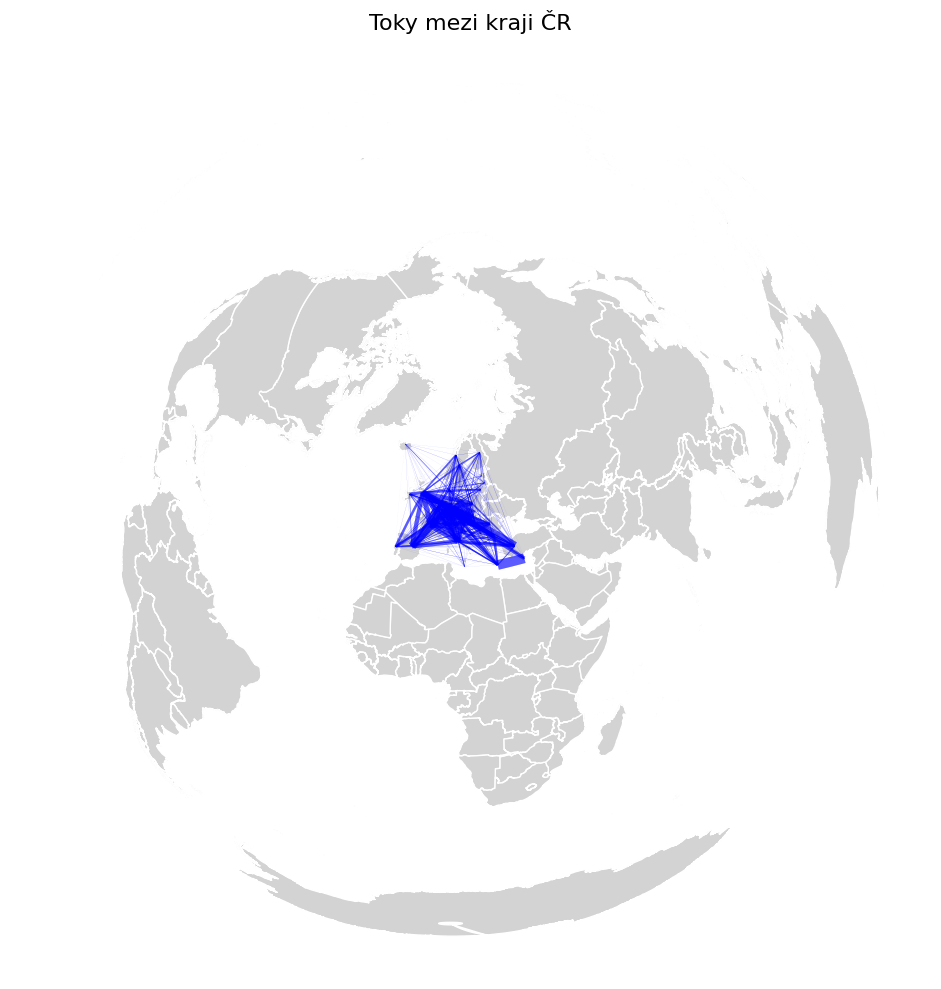

In [10]:
# Plot
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

# Plot regions, flows, and centroids
gdf_regions.plot(ax=ax, color='lightgrey', edgecolor='white')
gdf_flows_total.plot(ax=ax, linewidth=gdf_flows_total['value_total']/gdf_flows_total['value_total'].max()*20, color='blue', alpha=0.4)

# Set plot title and remove axis
ax.set_title("Toky mezi kraji ČR", fontsize=16)
ax.axis('off')

# Display the plot
plt.tight_layout()
plt.show()

In [12]:
# Převod sloupce 'pct' na float
result['pct'] = result['pct'].astype(float)

# Set coordinate reference system (adjust if needed)
result = result.set_crs(epsg=3035)

# Export to GeoPackage
result.to_file('../../data/europe/europe_flows.gpkg', driver='GPKG', layer='centroid_view')